# iRacing session results analysis

In [89]:
import requests
import json
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

 |->
 Input cell: 
 - enter subsession id and cookie to access session results:

In [90]:
subsession_id = '40751224'
cust_id = '35358774'
cookie = '4F6BDB8D05E0D142323A59D37AC6B85797A2B0170720EAC6B99906AA529ED0F3B83DD651586A85F1806608BF82493BFB6EEB9196B66E08830FE0CC4D2622DC46EEC948B780D7F57486BE2EEFBE30E679482D456191E59EF62C160395E628052023F035643F866753A6782DA0CC0F8B8CE7080BB13F3A185AFBE2CA959A4E8762'

Retrieve data from iRacing server:

In [91]:
cookies = {'irsso_membersv2': cookie}
payload = {'subsessionID': subsession_id, 'custid': cust_id }
response = requests.post('https://members.iracing.com/membersite/member/GetSubsessionResults', data=payload, cookies=cookies)

result_json = json.loads(response.text)

Retrieve a list of classes and checks if this is a team race for convenience:

In [92]:
rows = result_json['rows']
classes = []

is_team_race = (result_json['max_team_drivers'] > 1)

for row in rows:
    if row['simsestypename'] != 'Race' or (is_team_race and row['custid'] >= 0):
        continue
    current_class_name = row['ccName'].replace('+', ' ')
    if not current_class_name in classes:
        classes.append(current_class_name)
if is_team_race:
    print('This event is a team race')
else:
    print('This event is a single driver race')
print('Available classes:')
print(classes)

This event is a team race
Available classes:
['GT3 Class']


 |->
 Input cell: 
 - Set class filter if needed (or `None` if no class filtering required)
 - Set the car you want to flatten a gap graph (or `None` to flatten on a leader). Use driver name for single races and team name for team races

In [93]:
class_name = None
reference_car = None

Retrieve lap time data for each car in a session and pack it to a pandas dataframe 

In [94]:
df = pd.DataFrame(columns = ['Team name', 'Driver name', 'Class name', 'Finish position', 'Class finish position',  'Lap num', 'Lap time', 'Flags'])

maximum_lap_number = 0

driver_ids = {}
for row in rows:
    if row['simsestypename'] != 'Race' or (is_team_race and row['custid'] >= 0):
        continue
    current_class_name = row['ccName'].replace('+', ' ')
    if not class_name is None and current_class_name != class_name:
        continue

    if is_team_race:
        team_name = urllib.parse.unquote(row['displayname'].replace('+', ' '))
    else:
       team_name = '-'

    laps_response = requests.post('https://members.iracing.com/membersite/member/GetLaps?&subsessionid=' + subsession_id + '&groupid=' + str(row['custid']) + "&simsesnum=0", cookies=cookies)
    laps_json = json.loads(laps_response.text)

    drivers = laps_json['drivers']
    for driver in drivers:
        driver_ids[driver['custid']] = urllib.parse.unquote(driver['displayname'].replace('+', ' '))
    prev_lap_sess_time = 0
    laps = laps_json['lapData']
    for lap in laps:
        data = {}
        lap_time = (lap['ses_time'] - prev_lap_sess_time) / 10000.0
        prev_lap_sess_time = lap['ses_time']
        
        data['Team name'] = team_name
        data['Driver name'] = driver_ids[lap['custid']]
        data['Class name'] = current_class_name
        data['Finish position'] = row['finishpos'] + 1
        data['Class finish position'] = row['finishposinclass'] + 1
        data['Lap num'] = lap['lap_num']
        data['Lap time'] = lap_time
        data['Flags'] = lap['flags']

        df = df.append(data, ignore_index=True)

df


,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags
0,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,0,281.6833,0
1,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,1,83.0183,8192
2,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,2,78.7495,0
3,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,3,78.8293,0
4,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,4,78.8817,0
...,...,...,...,...,...,...,...,...
5633,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,0,281.7293,0
5634,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,1,2563.7017,10535
5635,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,2,218.5223,2307
5636,Rowe Racing,Gilles Hubin,GT3 Class,49,49,0,281.6903,1


Compute lap time delta from a reference car for each lap:

In [95]:
lap_idxs = list(df['Lap num'].unique())
grouped = df.groupby('Lap num')

deltas = pd.DataFrame(columns = ['Team name', 'Driver name', 'Lap time', 'Delta'])

if reference_car == None:
    if is_team_race:
        reference_car = df.loc[0]['Team name']
    else:
        reference_car = df.loc[0]['Driver name']


for lap_idx in lap_idxs:
    lap_results = grouped.get_group(lap_idx)
    current_leader_time = -1
    for index, row in lap_results.iterrows():    # first let's find the reference car lap time
        if (is_team_race and row['Team name'] == reference_car) or (not is_team_race and row['Driver name'] == reference_car):
            current_leader_time = row['Lap time']
    if current_leader_time > 0:
        current_lap_delta = pd.DataFrame(columns=['Delta'])
        current_lap_delta['Delta'] = lap_results.apply(lambda row: row['Lap time'] - current_leader_time, axis=1)
        deltas = deltas.append(current_lap_delta)

deltas = deltas.filter(['Delta'])
df = df.merge(deltas, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta
0,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,0,281.6833,0,0.0000
1,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,1,83.0183,8192,0.0000
2,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,2,78.7495,0,0.0000
3,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,3,78.8293,0,0.0000
4,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,4,78.8817,0,0.0000
...,...,...,...,...,...,...,...,...,...
5633,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,0,281.7293,0,0.0460
5634,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,1,2563.7017,10535,2480.6834
5635,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,2,218.5223,2307,139.7728
5636,Rowe Racing,Gilles Hubin,GT3 Class,49,49,0,281.6903,1,0.0070


Compute accumulated gap from a leader car for each car:

In [96]:
if is_team_race:
    car_id_column = 'Team name'
else:
    car_id_column = 'Driver name'
car_ids = list(df[car_id_column].unique())

gaps = pd.DataFrame(columns = ['Delta', 'Gap'])

grouped = df.groupby(car_id_column)
for carId in car_ids:
    car_results = grouped.get_group(carId)
    car_results = car_results.filter(['Delta'])
    gap = 0
    for index, row in car_results.iterrows():
        gap += row['Delta']
        car_results.at[index, 'Gap'] = gap
    gaps = gaps.append(car_results)
gaps = gaps.filter(['Gap'])
df = df.merge(gaps, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta,Gap
0,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,0,281.6833,0,0.0000,0.0000
1,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,1,83.0183,8192,0.0000,0.0000
2,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,2,78.7495,0,0.0000,0.0000
3,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,3,78.8293,0,0.0000,0.0000
4,PGZ Motorsport,Pablo Araujo5,GT3 Class,1,1,4,78.8817,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...
5633,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,0,281.7293,0,0.0460,0.0460
5634,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,1,2563.7017,10535,2480.6834,2480.7294
5635,COMRADES SIMSPORT RED,Anders Lyhne Vaaben,GT3 Class,48,48,2,218.5223,2307,139.7728,2620.5022
5636,Rowe Racing,Gilles Hubin,GT3 Class,49,49,0,281.6903,1,0.0070,0.0070


Basic data is ready, now we can build some nice graphs:

In [97]:
data = []
labels = []

grouped = df.groupby(car_id_column)
for car_id in car_ids:
    labels.append(car_id)
    car_results = grouped.get_group(car_id)
    data.append(car_results['Gap'].values)


Gap graph:

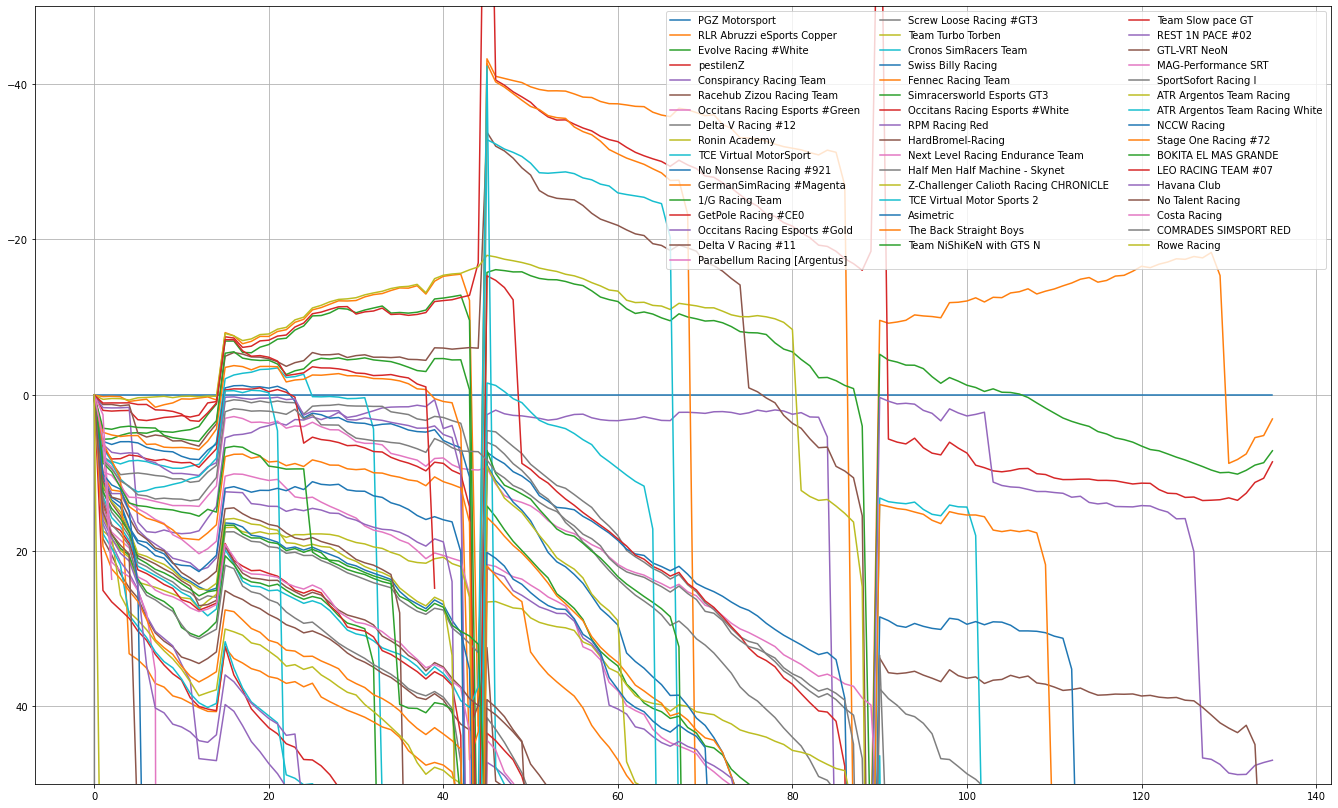

In [108]:
plt.rcParams['figure.figsize'] = [20, 12]

for i, gap in enumerate(data):
    plt.plot(gap, label=labels[i])
plt.legend(ncol=3)
plt.grid(True)
plt.gca().set_ylim([50, -50])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()

 |->
 Input cell: 
 - Set a team to build driver lap times histogram or `None` to build it for all drivers

In [114]:
build_histogram_for = 'PGZ Motorsport'

C:\Python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


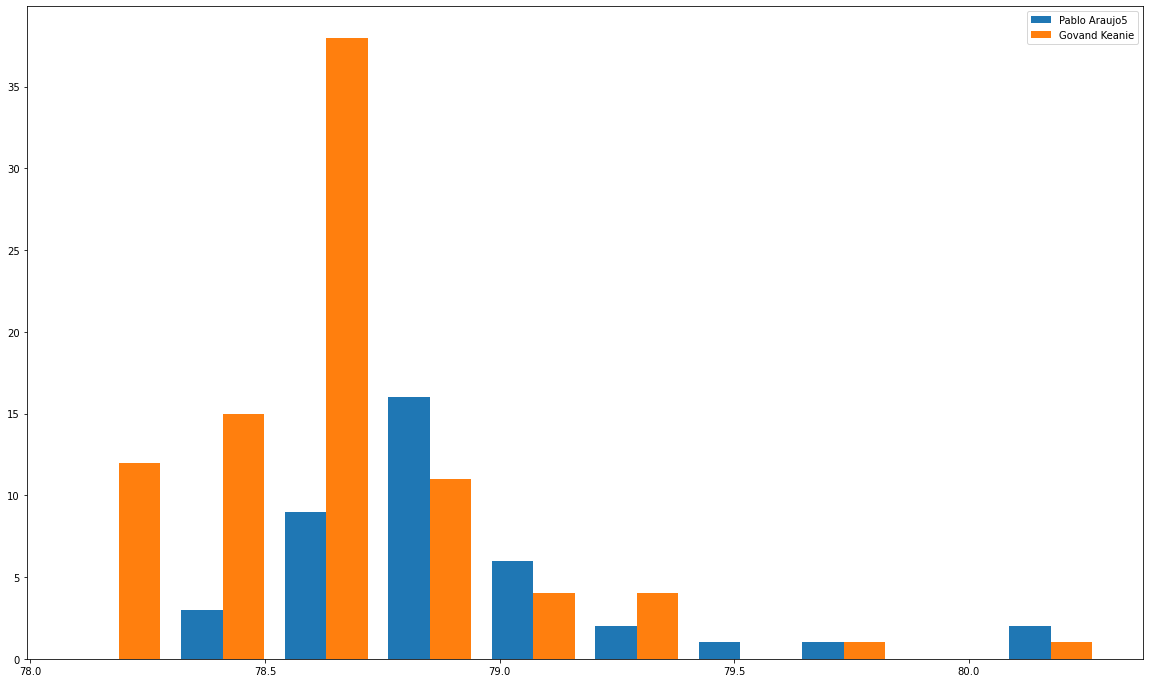

In [115]:
if build_histogram_for == None:
    if class_name == None:
        drivers = df['Driver name'].unique()
    else:
        drivers = df[df['Class name'] == class_name]['Driver name'].unique()
else:
    drivers = df[df['Team name'] == build_histogram_for]['Driver name'].unique()

lap_times = {}

fastest = 1e+25

for driver in drivers:
    lap_times[driver] = df[df['Driver name'] == driver]['Lap time'].tolist()
    local_fastest = min(lap_times[driver])
    fastest = min(fastest, local_fastest)

for driver in drivers:
    times = lap_times[driver]
    lap_times[driver] = [t for t in times if t <= fastest * 1.03]


driver_names = list(lap_times.keys())
driver_lap_times = list(lap_times.values())

plt.hist(driver_lap_times, label=driver_names)
plt.legend()

plt.show()

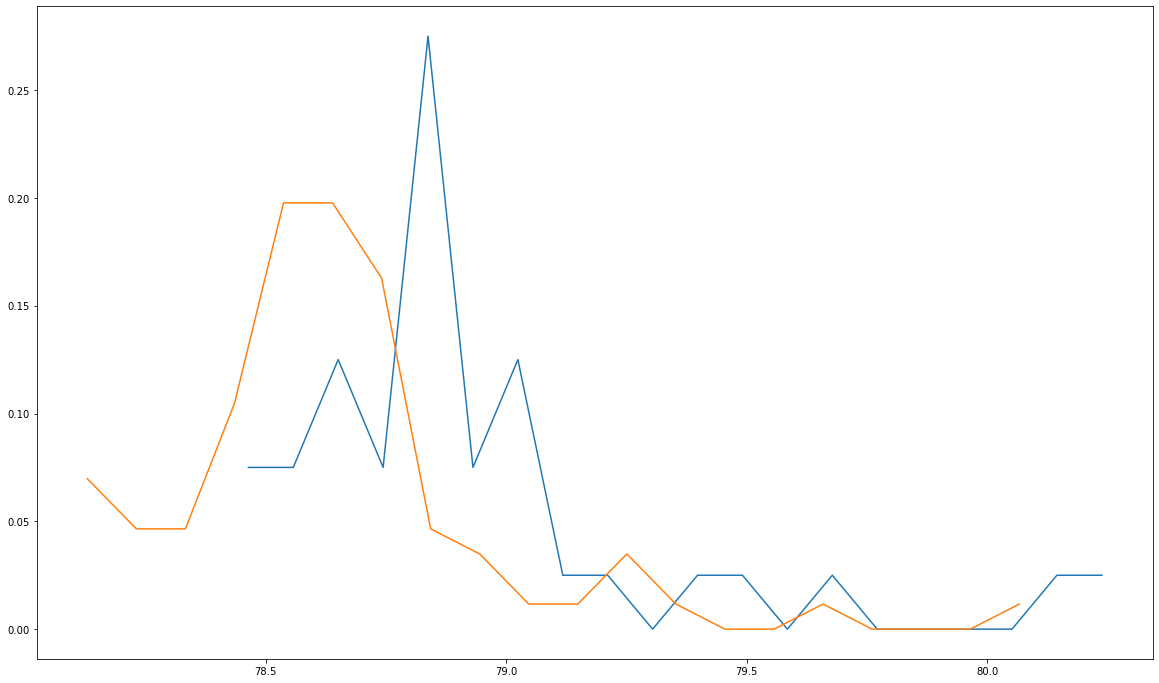

In [116]:
for driver in drivers:
    data = np.asarray(lap_times[driver])
    y, bin_edges = np.histogram(data, bins=20)
    y = y / len(lap_times[driver])
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_centers, y)

plt.show()


In [117]:
def seconds_to_lap_time(t):
    minutes = int(t / 60)
    seconds = int(t  - minutes * 60)
    ms = int((t - minutes * 60 - seconds) * 1000)
    return str(minutes) + ":" + str(seconds).zfill(2) + "." + str(ms).zfill(3)

In [118]:
for driver, times in lap_times.items():
    print('Mean lap time:   ', driver, ': ', seconds_to_lap_time(np.mean(times)))
    print('Median lap time: ', driver, ': ', seconds_to_lap_time(np.median(times)))
    print('Lap time st.dev: ', driver, ': ', round(np.std(times), 3), "s")
    print('Valid laps:      ', driver, ': ', len(times))

Mean lap time:    Pablo Araujo5 :  1:18.924
Median lap time:  Pablo Araujo5 :  1:18.854
Lap time st.dev:  Pablo Araujo5 :  0.398 s
Valid laps:       Pablo Araujo5 :  40
Mean lap time:    Govand Keanie :  1:18.637
Median lap time:  Govand Keanie :  1:18.594
Lap time st.dev:  Govand Keanie :  0.327 s
Valid laps:       Govand Keanie :  86


In [119]:
from enum import IntFlag
class LapFlags(IntFlag):
    NONE = 0
    INVALID = 1
    PITTED = 2
    OFFTRACK = 4
    # ...
    CAR_CONTACT = 64

average_clean_lap = df[df['Flags'] & LapFlags.PITTED == 0]['Lap time'].mean()

df['Pitted'] = 0
df['Pit time loss'] = 0
for i in range(len(df) - 1):
    if i == 0:
        continue
    if df.iloc[i]['Flags'] & LapFlags.PITTED:
        df.iloc[i - 1, df.columns.get_loc('Pitted')] = 1
        df.iloc[i, df.columns.get_loc('Pitted')] = 2
        df.iloc[i + 1, df.columns.get_loc('Pitted')] = 3
        time_spent = df.iloc[i - 1]['Lap time'] + df.iloc[i]['Lap time'] + df.iloc[i + 1]['Lap time']
        time_loss = time_spent - 3 * average_clean_lap
        df.iloc[i, df.columns.get_loc('Pit time loss')] = time_loss


df_filteded = df
df_pits = df_filteded[df_filteded['Pitted'] != 0]
pd.set_option('display.max_rows', 500)

# df_filteded

In [120]:
df_filteded = df_filteded[df_filteded['Pit time loss'] > 0]
df_filteded

if is_team_race:
    key = 'Team name' 
else:
    key = 'Driver name'

df_pits = df_filteded.groupby(key, sort=False)['Lap num'].nunique().to_frame().rename(columns={'Lap num': 'Pits'})

maximum_pit_amount = df_pits['Pits'].max()

for i in range(maximum_pit_amount):
    name = str(i + 1)
    df_pits[name] = ''

names = df_pits.index.unique()

losses = []

for name in names:
    df_team = df_filteded[df_filteded[key] == name]
    for i in range(len(df_team)):
        loss = int(df_team.iloc[i]['Pit time loss'])
        losses.append(loss)
        lap = df_team.iloc[i]['Lap num']
        minutes = int(loss / 60)
        seconds = loss - minutes * 60
        df_pits.loc[name, str(i + 1)] = str(lap) + ' (' + str(minutes) + ':' + str(seconds).zfill(2) + ')'

df_pits

,Pits,1,2,3,4,5
Team name,,,,,,
PGZ Motorsport,2,45 (1:21),90 (1:01),,,
RLR Abruzzi eSports Copper,3,44 (0:53),87 (1:19),130 (0:17),,
Evolve Racing #White,2,44 (1:18),89 (0:56),,,
pestilenZ,2,46 (0:54),91 (1:22),,,
Conspirancy Racing Team,3,43 (1:19),85 (0:54),127 (0:21),,
Racehub Zizou Racing Team,3,45 (0:55),89 (1:23),134 (0:18),,
Occitans Racing Esports #Green,2,45 (1:23),90 (1:22),,,
Delta V Racing #12,2,44 (1:22),89 (0:57),,,
Ronin Academy,2,45 (1:19),89 (1:36),,,
